In [29]:
from concurrent.futures import ProcessPoolExecutor
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from aux import *
from z3 import *
import time

# Problema 1: Horário de uma Startup

Há $P$ projetos, enumerados de $(0, ..., P-1)$. 

Cada projeto $p$ tem $C_p$ colaboradores $(0, ..., C_p-1)$ dos quais um é líder.

Para cada projeto $p$ há $N_p$ reuniões semanais.

As reuniões têm de conter sempre o líder e pelo menos $50\%$ dos colaboradores.

As reuniões ocorrem em uma das $S$ salas enumeradas de $(0, ..., S-1)$.

Os tempos são representados por slots $(\mathit{hora}, \mathit{dia})$.

## Variáveis do problema

$x_{p, c, d, h}$: inteiro que representa a disponibilidade do colaborador $c$ do projeto $p$, onde $c=0$ é o líder, $d$ é o dia e $h$ a hora desse dia

$y_{s, d, h, p}$: inteiro que representa a disponibilidade da sala $s$ no dia $d$ e hora $h$ para o projeto $p$.


$r_{p, d, h, s}:$ inteiro que representa a existência de uma reunião para o projeto $p$ no dia $d$, hora $h$ e sala $s$.

## Condições inerentes ao problema

1. Todos os valores são inteiros unitários ou nulos:

$$ 0 \le x_{p,c,d,h} \le 1, \forall_{p,c,d,h} $$
$$ 0 \le y_{s,d,h,p} \le 1, \forall_{s,d,h,p} $$
$$ 0 \le r_{p,d,h,s} \le 1, \forall_{p,d,h,s} $$

2. Cada sala, por dia e hora, está disponível para reunião de apenas um projeto:

$$ \sum_{p=0}^{P-1} y_{s,d,h,p} = 1, \forall_{s, d, h} $$

3. Cada projeto só pode ter no máximo uma reunião por dia e hora:

$$ \sum_{s=0}^{S-1} r_{p,d,h,s} \le 1, \forall_{p,d,h} $$

4. Para haver reunião de um projeto numa certa sala, dia e hora, o líder e pelo menos $50\%$ dos colaboradores devem estar disponíveis e a sala também:

$$ r_{p,d,h,s} = 1 \rightarrow \left( y_{s,d,h,p} = 1 \wedge x_{p,0,d,h} = 1 \wedge \sum_{c=1}^{C_p-1} x_{p,c,d,h} \ge \frac{C_p-1}{2} \right), \forall_{p,d,h,s} $$

## Condições de input

1. A disponibilidade dos colaboradores de cada projeto $x_{p,c,d,h}^{(i)}$ é dada como input do problema:

$$ x_{p,c,d,h} = x_{p,c,d,h}^{(i)}, \forall_{p,c,d,h} $$

2. Deve haver um número mínimo de reuniões semanais por projeto $N_p$, dada como input do problema:

$$ \sum_{d=0}^{D-1} \sum_{h=h_i}^{h_f} \sum_{s=0}^{S-1} r_{p,d,h,s} \ge N_p, \forall_p $$

## Condição opcional

1. Se possível, marcar no máximo uma reunião por dia:

$$ \sum_{h=h_i}^{h_f} \sum_{s=0}^{S-1} r_{p,d,h,s} \le 1, \forall_{p,d} $$

2. Para reuniões consecutivas do mesmo projeto, estas devem ser sempre na mesma sala:

$$ r_{p,d,h,s} + \sum_{s < s\prime < S} r_{p, d, h+1, s\prime} \le 1, \forall_{p,s<S-1,d,h<h_f-1} $$

In [30]:
def get_meetings(self):
    # Variáveis auxiliares
    days = ["mon", "tue", "wed", "thu", "fri"]
    rooms = self.rooms
    x_in = self.x_in

    solver = Solver()
    # Criar os dicionários de inteiros x, y e r descritos anteriormente
    x = {p: {c: {d: {h: Int(f'x:{p},{c},{d},{h}') for h in range(8, 17)} for d in days} for c in x_in[p]} for p in x_in}
    y = {s: {d: {h: {p: Int(f'y:{s},{d},{h},{p}') for p in x_in} for h in range(8, 17)} for d in days} for s in rooms}
    r = {p: {d: {h: {s: Int(f'r:{p},{s},{d},{h}') for s in rooms} for h in range(8, 17)} for d in days} for p in x_in}

    # Condição inerente 1 e de input 1
    for p in x:
        for c in x[p]:
            for d in x[p][c]:
                for h in x[p][c][d]:
                    solver.add(x[p][c][d][h] >= 0, x[p][c][d][h] <= 1)
                    solver.add(x[p][c][d][h] == x_in[p][c][d][h])
    for s in y:
        for d in y[s]:
            for h in y[s][d]:
                for p in y[s][d][h]:
                    solver.add(y[s][d][h][p] <= 1, y[s][d][h][p] >= 0)
                    solver.add(r[p][d][h][s] <= 1, r[p][d][h][s] >= 0)

    # Condição inerente 2
    for s in y:
        for d in y[s]:
            for h in y[s][d]:
                solver.add(Sum([y[s][d][h][p] for p in y[s][d][h]]) == 1)
                
    # Condição inerente 3
    for p in r:
        for d in r[p]:
            for h in r[p][d]:
                solver.add(Sum([r[p][d][h][s] for s in r[p][d][h]]) <= 1)

    # Condição inerente 4
    for p in r:
        C = len(x_in[p])
        for d in r[p]:
            for h in r[p][d]:
                for s in r[p][d][h]:
                    solver.add(Implies(r[p][d][h][s] == 1, x[p][0][d][h] >= 1))
                    solver.add(Implies(r[p][d][h][s] == 1, y[s][d][h][p] >= 1))
                    solver.add(Implies(r[p][d][h][s] == 1, Sum([x[p][c][d][h] for c in range(1, C)]) >= (C-1)/2))
                    
    # Condição de input 2
    for p in r:
        N = self.num_meetings[p]
        soma = 0
        for d in r[p]:
            for h in r[p][d]:
                for s in r[p][d][h]:
                    soma += r[p][d][h][s]
        solver.add(soma >= N)
        
    # Condição opcional de reuniões seguidas terem a mesma sala
    solver.push()
    for p in r:
        for d in r[p]:
            for h in r[p][d]:
                if h < 16:
                    for s in r[p][d][h]:
                        solver.add(r[p][d][h][s] + Sum([r[p][d][h+1][s_] for s_ in r[p][d][h+1] if s_ > s]) <= 1)
        
    # Condição opcional de uma reunião máxima por dia
    solver.push()
    for p in r:
        for d in r[p]:
            soma = 0
            for h in r[p][d]:
                for s in r[p][d][h]:
                    soma += r[p][d][h][s]
            solver.add(soma <= 1)
        
    if solver.check() == sat: # Verificar satisfatibilidade
        print("\nThis schedule is solvable.\n")
        m = solver.model()
    else: # Condições não verificadas
        solver.pop() # Remover condição de dias separados
        if solver.check() == sat:
            print("\nThis schedule is solvable with more than one meeting a day.\n")
            m = solver.model()
        else: # Condição opcional
            solver.pop() # Remover condição de reuniões consecutivas
            if solver.check() == sat: # Horário satisfazível sem a condição opcional
                print("\nThis schedule is solvable, but with more than one meeting a day and consecutive meetings might have different rooms\n")
                m = solver.model()
            else: # Horário insatisfazível
                print("\nThis schedule is not solvable!\n")
                m = None
            
    if m != None: # Se o horário for satisfazível
        # Converter os dias das reuniões numa lista de tuplos
        result = [tuple(str(elem).split(',')) for elem in m if "r:" in str(elem) and m[elem] == 1]
        result = sorted([(r1.split(':')[1], r3, r4, r2) for (r1, r2, r3, r4) in result])
        
        # Converter essa lista de tuplos num dataframe do pandas
        result = meeting_to_df(result)
        
        # Mostrar o resultado do horário e exportá-lo como ficheiro csv
        display(pd_centered(result))
        result.to_csv("schedule.csv")   
    else: # Se o horário não for satisfazível
        result = None
        
    return result
                    
Schedule.get_meetings = get_meetings

In [31]:
# Definir as salas disponíveis
rooms = ["S1", "S2", "S3", "S4", "S5"]

# Transformar os dados dos ficheiros csv num objeto da classe Schedule
path = "Projetos"
startup = get_schedule(path, rooms)

# Chamar a função que determina os horários
r = startup.get_meetings()

How many meetings should be held for project TMNT this week? 6
How many meetings should be held for project Logica this week? 6
How many meetings should be held for project The_Beatles this week? 6
How many meetings should be held for project The_Office this week? 6



This schedule is solvable with more than one meeting a day.



,mon,tue,wed,thu,fri
8h-9h,| Logica - S2 || TMNT - S3 || The_Office - S1 |,| Logica - S3 || The_Beatles - S2 || The_Office - S1 |,| Logica - S1 |,| Logica - S1 |,
9h-10h,| The_Beatles - S1 |,| TMNT - S2 || The_Office - S1 |,,,
10h-11h,| The_Beatles - S1 |,,,,
11h-12h,| Logica - S2 || The_Office - S1 |,,,,
12h-13h,| TMNT - S1 |,,,,
13h-14h,,,,,
14h-15h,| TMNT - S3 || The_Beatles - S2 |,| Logica - S1 || TMNT - S2 |,,,
15h-16h,| TMNT - S3 || The_Beatles - S2 || The_Office - S1 |,,,,
16h-17h,| The_Beatles - S2 || The_Office - S1 |,,,,


# Problema 2: Pidgeon Hole Principle

Se disposermos de $N$ pombos e $N-1$ poleiros, é impossível colocar um pombo em cada poleiro.

Seja $p_{n, m}$ a variável que representa a presença do pombo $n$ no poleiro $m$.

## Condições Lógica Inteira

1. Cada pombo deve ocupar sempre um e um só poleiro:
$$ \sum_{m=0}^{N-2} p_{n,m} = 1, \forall_n $$

2. Cada poleiro pode apenas ter no máximo um pombo:
$$ \sum_{n=0}^{N-1} p_{n, m} \le 1, \forall_m $$

In [32]:
def php_int(N):
    start = time.time()
    
    # Criar o solver e as variáveis
    solver = Solver()
    p = [[Int(f'{n},{m}') for m in range(N-1)] for n in range(N)]
    
    # Condição 1: Cada pombo deve ocupar sempre um poleiro
    for n in p:
        solver.add(sum([m for m in n]) == 1)
    
    # Condição 2: Cada poleiro deve conter no máximo um pombo
    p = list(np.array(p).transpose())
    for m in p:
        solver.add(sum([n for n in m]) <= 1)
        
    # Verificar que é insatisfazível
    assert solver.check() == unsat
    
    return time.time() - start

## Condições Lógica Proposicional

1. Cada pombo deve ocupar sempre um e um só poleiro, ou seja, cada pombo deve ocupar pelo menos um poleiro (1) e cada pombo deve ocupar no máximo um poleiro (2):
\begin{equation}
\bigvee_{m=0}^{N-2} p_{n,m}, \forall_n
\tag{1}
\end{equation}

\begin{equation}
p_{n, m} \rightarrow \bigwedge_{i=0, i \neq m}^{N-2} \left( \neg p_{n, i} \right) \forall_{n,m}
\tag{2}
\end{equation}

2. Cada poleiro tem no máximo um pombo:
$$ p_{n, m} \rightarrow \bigwedge_{i=0, i \neq n}^{N-1} \left( \neg p_{i, m} \right), \forall_{n, m} $$

In [33]:
def php_bool(N):
    start = time.time()
    
    # Criar o solver e as variáveis
    solver = Solver()
    p = [[Bool(f'{n},{m}') for m in range(N-1)] for n in range(N)]
    
    # Condição 1: Cada pombo deve ocupar sempre um poleiro
    for i in range(len(p)):
        solver.add(Or([p[i][j] for j in range(len(p[i]))]))
        for j in range(len(p[i])):
            conds = []
            for k in range(len(p[i])):
                if j != k:
                    conds.append(Not(p[i][k]))
            solver.add(Implies(p[i][j], And(conds)))

    # Condição 2: Cada poleiro deve conter no máximo um pombo
    for i in range(len(p)):
        for j in range(len(p[i])):
            conds = []
            for k in range(len(p)):
                if j != k:
                    conds.append(Not(p[k][j]))
            solver.add(Implies(p[i][j], And(conds)))

    # Verificar que é insatisfazível
    assert solver.check() == unsat

    return time.time() - start

In [34]:
num_max = 20
times_int, times_bool = [], []
for i in tqdm(range(1, num_max+1), total=num_max, desc="PHP"):
    times_int.append(php_int(i))
    times_bool.append(php_bool(i))

PHP: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


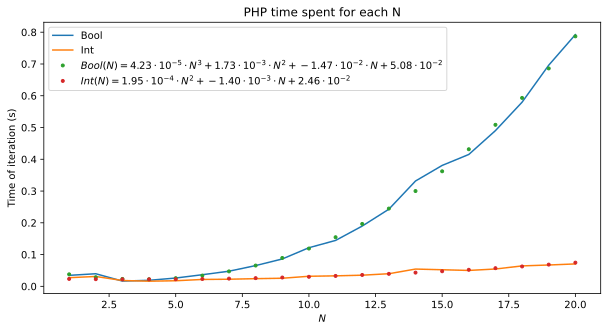

In [37]:
x_axis = [i for i in range(1, num_max+1)]
poly3_c = np.polyfit(x_axis,times_bool,3)
poly2_c = np.polyfit(x_axis,times_int,2)
poly3 = [sum([poly3_c[i] * x ** (3-i) for i in range(len(poly3_c))]) for x in x_axis]
poly2 = [sum([poly2_c[i] * x ** (2-i) for i in range(len(poly2_c))]) for x in x_axis]
poly3_c = [f'{p:.2e}'.split('e')[0] + " \\cdot 10^{" + f"{p:.2e}".split('e')[1].replace('0','') + "}" for p in poly3_c]
poly2_c = [f'{p:.2e}'.split('e')[0] + " \\cdot 10^{" + f"{p:.2e}".split('e')[1].replace('0','') + "}" for p in poly2_c]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_title("PHP time spent for each N")
ax.plot(x_axis, times_bool, label="Bool")
ax.plot(x_axis, times_int, label="Int")
ax.plot(x_axis, poly3,".", label=f"$Bool(N) = {poly3_c[0]} \\cdot N^3 + {poly3_c[1]} \\cdot N^2 + {poly3_c[2]} \\cdot N + {poly3_c[3]}$")
ax.plot(x_axis, poly2, ".",label=f"$Int(N) = {poly2_c[0]} \\cdot N^2 + {poly2_c[1]} \\cdot N + {poly2_c[2]}$")
ax.set_ylabel("Time of iteration (s)")
ax.set_xlabel("$N$")
ax.legend()

plt.show()